In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from os.path import join
from itertools import chain
from pyvttbl import Anova1way
import matplotlib.gridspec as gridspec

sns.set_style('darkgrid')

/home/data/nbc/physics-learning/physics-learning/env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
group1 = [216, 218, 323, 330, 334, 335, 337, 339, 341, 347, 348, 453, 467, 572, 574, 598, 606, 607, 615, 623, 626, 627, 631, 634]
group2 = [103, 107, 219, 327, 336, 338, 451, 463, 470, 581, 586, 587, 608, 609, 613, 619, 620]
group3 = [215, 321, 349, 460, 468, 582, 585, 588, 595, 630]
groups = [group1, group2, group3]
d = {}
d['group1'] = group1
d['group2'] = group2
d['group3'] = group3
allsubj = list(chain(*groups))

In [3]:
f_path = '/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral/datafiles'
f = join(f_path, 'fci_accuracy_rt.txt')

df = pd.read_csv(f, sep='\t')
columns = ['Mean FCI RT', 'Mean Non-FCI RT']
df = df[df.Session == 'session-1']
df = df.drop(['Session', 'Mean FCI Accuracy','Mean Non-FCI Accuracy', 'Mean FCI Screen1 RT', 
           'Mean Non-FCI Screen1 RT', 'Mean FCI Screen2 RT', 'Mean Non-FCI Screen2 RT', 
           'Mean FCI Screen3 RT', 'Mean Non-FCI Screen3 RT'], axis = 1)
df = df[df['Subject'].isin(allsubj)]
df['FCI-Control RT Difference'] = df['Mean FCI RT']
print df.shape
df.head()

(51, 4)


,Subject,Mean FCI RT,Mean Non-FCI RT,FCI-Control RT Difference
5,103,23510.333333,17462.000000,23510.333333
11,107,20025.222222,15737.444444,20025.222222
22,215,17362.555556,14346.777778,17362.555556
24,216,15742.666667,12181.333333,15742.666667
28,218,21071.222222,22689.777778,21071.222222


In [4]:
def rem(string):
    return string.replace(' RT', '')

def fci(string):
    if 'Non-FCI' in string:
        return 'Control'
    else:
        return 'FCI'

def remfci(string):
    return string.replace(' Non-FCI', '').replace(' FCI', '')

def changegroupname(string):
    if 'group1' in string:
        return string.replace('group1', 'Group A')
    elif 'group2' in string:
        return string.replace('group2', 'Group B')
    elif 'group3' in string:
        return string.replace('group3', 'Group C')
    else:
        return 'unknown'

def rep(string):
    if string == 'session-0':
        return 'Pre'
    elif string == 'session-1':
        return 'Post'
    else:
        return 'Unknown'
                    

all_cols = columns + ['Subject']
df2 = df[all_cols]
df3 = pd.melt(df2, id_vars=['Subject'], var_name='Measure',
              value_vars=columns, value_name='Reaction Time')

# make new column named 'Condition' and populate it with condition type
df3['Condition'] = df3['Measure'].apply(fci)

# merge two cols into one and population 'Measure' with originating col name
df3['Measure'] = df3['Measure'].apply(remfci)
df3['Measure'] = df3['Measure'].apply(rem)

# make new column 'Group' and populate it with subj group ID
subjlist = []
for i in range(0,len(df3.Subject)):
    for key in d.keys():
        if df3.Subject[i] in d[key]:
            subjlist.append(key)
df3['Group'] = subjlist
df3 = df3.sort_values('Group', ascending=True)
df4 = df3.copy()
df4['Group'] = df4['Group'].apply(changegroupname)
df4.head()

,Subject,Measure,Reaction Time,Condition,Group
50,634,Mean,19441.111111,FCI,Group A
38,607,Mean,12944.888889,FCI,Group A
42,615,Mean,23034.555556,FCI,Group A
45,623,Mean,20219.000000,FCI,Group A
46,626,Mean,21940.333333,FCI,Group A


/home/data/nbc/physics-learning/physics-learning/env/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


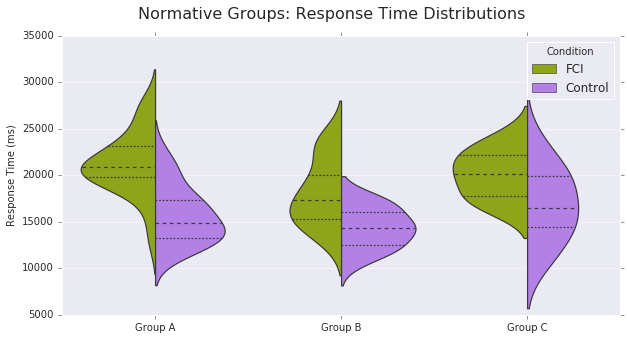

In [5]:
# plots distributions without interaction/swarm plots
colors = ['bright olive', 'light urple']

fig, ax = plt.subplots(figsize=(10, 5))

sns.violinplot(x='Group', y='Reaction Time', hue='Condition', inner='quart', linewidth=1.2,
               split=True, data=df4, ax=ax, palette=sns.xkcd_palette(colors))

fig.suptitle('Normative Groups: Response Time Distributions', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Response Time (ms)')

fig.savefig('rt_dist.png', dpi=400)
fig.show()

In [6]:
# separate dfs by group
rt1 = df3[df3['Group'] == 'group1']
rt2 = df3[df3['Group'] == 'group2']
rt3 = df3[df3['Group'] == 'group3']

# separate dfs by condition
rt1_fci = rt1[rt1['Condition'] == 'FCI']
rt2_fci = rt2[rt2['Condition'] == 'FCI']
rt3_fci = rt3[rt3['Condition'] == 'FCI']
rt1_control = rt1[rt1['Condition'] == 'Control']
rt2_control = rt2[rt2['Condition'] == 'Control']
rt3_control = rt3[rt3['Condition'] == 'Control']

# create data structure for one way ANOVA
rt_fci_grp1 = rt1_fci['Reaction Time'].tolist()
rt_fci_grp2 = rt2_fci['Reaction Time'].tolist()
rt_fci_grp3 = rt3_fci['Reaction Time'].tolist()
rt_control_grp1 = rt1_control['Reaction Time'].tolist()
rt_control_grp2 = rt2_control['Reaction Time'].tolist()
rt_control_grp3 = rt3_control['Reaction Time'].tolist()

# convert to seconds because the anova1way method apparetnyl can't deal with large numbers
rt_fci_grp1_sec = [i * 1e-3 for i in rt_fci_grp1]
rt_fci_grp2_sec = [i * 1e-3 for i in rt_fci_grp2]
rt_fci_grp3_sec = [i * 1e-3 for i in rt_fci_grp3]
rt_control_grp1_sec = [i * 1e-3 for i in rt_control_grp1]
rt_control_grp2_sec = [i * 1e-3 for i in rt_control_grp2]
rt_control_grp3_sec = [i * 1e-3 for i in rt_control_grp3]

data_fci = [rt_fci_grp1_sec, rt_fci_grp2_sec, rt_fci_grp3_sec]
data_control = [rt_control_grp1_sec, rt_control_grp2_sec, rt_control_grp3_sec]

df_rt_fcicontrol = df3.copy()
df_rt_fcicontrol = df_rt_fcicontrol.drop(['Measure'], axis = 1)
df_rt_fcicontrol = df_rt_fcicontrol.rename(index=str, columns={"Reaction Time": "RT"})
df_rt_fcicontrol['Group'] = df_rt_fcicontrol['Group'].apply(changegroupname)
df_rt_fcicontrol = df_rt_fcicontrol.set_index('Subject')
df_rt_fcicontrol.to_csv('group_rt_cond.txt', sep='\t')
print df_rt_fcicontrol.head()

                   RT Condition    Group
Subject                                 
634      19441.111111       FCI  Group A
607      12944.888889       FCI  Group A
615      23034.555556       FCI  Group A
623      20219.000000       FCI  Group A
626      21940.333333       FCI  Group A


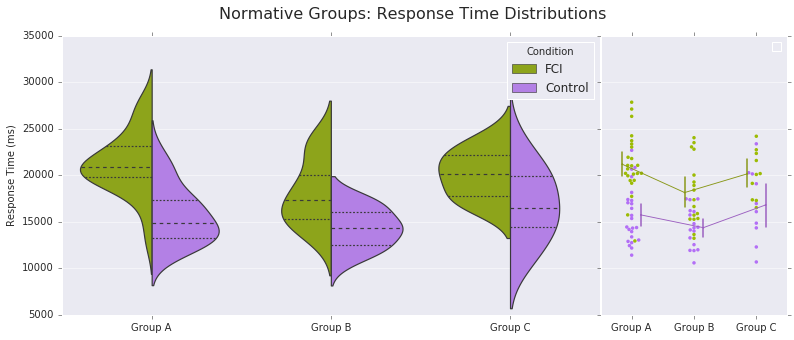

In [7]:
# plots distributions with interaction/swarm plots
linewidth = 0.5
colors = ['bright olive', 'light urple']
dark_colors = ['baby shit green', 'amethyst']

fig = plt.figure(figsize=(13,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.3, .8])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

sns.violinplot(x='Group', y='Reaction Time', hue='Condition', inner='quart', linewidth=1.2,
               split=True, data=df4, ax=ax0, palette=sns.xkcd_palette(colors))
sns.swarmplot(x="Group", y="RT", hue="Condition", size=3.5,
              data=df_rt_fcicontrol, palette=sns.xkcd_palette(colors), ax=ax1, zorder=1)
sns.pointplot(x="Group", y="RT", hue="Condition", 
              data=df_rt_fcicontrol, ax=ax1, zorder=100, dodge=.3, scale=linewidth, 
              palette=sns.xkcd_palette(dark_colors), errwidth=linewidth+1, markers='.')

fig.suptitle('Normative Groups: Response Time Distributions', fontsize=16)
ax1.set_ylim(bottom=5000, top=35000)
ax1.set_yticklabels([])
ax0.set_xlabel('')
ax1.set_xlabel('')
ax0.set_ylabel('Response Time (ms)')
ax1.set_ylabel('')
ax1.legend('')
plt.subplots_adjust(wspace=.0025)

fig.savefig('rt_dist_winteraction.png', dpi=400)
fig.show()

In [8]:
# run ANOVA to test means
conditions_list = 'group1 group2 group3'.split()

# test FCI RTs
D1 = Anova1way()
D1.run(data_fci, conditions_list=conditions_list)
print 'FCI RTs: One-way ANOVA'
print D1

# test Control RTs
D2 = Anova1way()
D2.run(data_control, conditions_list=conditions_list)
print '-----------------------------------------------------------------------------------------------'
print 'Control RTs: One-way ANOVA'
print D2

FCI RTs: One-way ANOVA
Anova: Single Factor on Measure

SUMMARY
Groups   Count     Sum     Average   Variance 
group1      24   508.453    21.186     11.160 
group2      17   308.444    18.144     12.338 
group3      10   201.477    20.148      6.693 

O'BRIEN TEST FOR HOMOGENEITY OF VARIANCE
Source of Variation      SS       df     MS        F     P-value   eta^2   Obs. power 
Treatments              211.173    2   105.586   0.465     0.631   0.019        0.125 
Error                 10889.084   48   226.856                                        
Total                 11100.257   50                                                  

ANOVA
Source of Variation     SS      df     MS       F     P-value   eta^2   Obs. power 
Treatments             92.474    2   46.237   4.315     0.019   0.152        0.675 
Error                 514.323   48   10.715                                        
Total                 606.798   50                                                 

POSTHOC MULTIP